### Part 1

The link to the full repository is:
https://github.com/FabianScott/ComSoc
We did some exercises along with members from another group, so they have also comitted some code, however the assignment was done independently.

In [3]:
from bs4 import BeautifulSoup
import requests
import re

In [4]:
# link to the page we want to scrape
link = "https://2019.ic2s2.org/oral-presentations/"
r = requests.get(link)
soup = BeautifulSoup(r.content)

### 1. By inspecting the HTML code, we found a pattern of the names being located just after a timestamp. We exploited this in the following code to find the researchers:

In [5]:
# create pattern to find all time stamps in the page
pattern = r"\d+\d+:\d+\d+.*\."
# find all the names in current time stamp
pattern_names = r"([A-Z][a-z]+ [A-Z][a-z]+(, [A-Z][a-z]+ [A-Z][a-z]+)*\.)"
times = re.findall(pattern, str(soup.find_all("p")))
names_nonprocessed = re.findall(pattern_names, str(times))
unique_names = []
for element in names_nonprocessed:
    for i in element:
        # strip name of punctuation and spaces, then split every name for the current time stamp
        x = i.strip(",.").strip().split(",")
        # if multiple names:
        if len(x) > 1:
            for name in x:
                name = str(name.strip())
                if name not in unique_names:
                    unique_names.append(name)
        else:
        # if only one name:
            if x[0] not in unique_names:
                unique_names.append(x[0])

In [7]:
print(len(unique_names))

335


We found 335 unique names from the oral presentation website for the 2019 conference. Here in the following section we include the 2020 conference as it is scraped in a different manner. The site links to a spreadsheet which includes the names:

### 2020

In [8]:
link = "https://docs.google.com/spreadsheets/u/0/d/e/2PACX-1vTX9_1Xftn7D-nSI8X9b7tafr_Z0kAbphKdfZ8qUSU9p-syXNsGPdhHl5ZyTnKKL-T6dCEJqtsrn3wy/pubhtml/sheet?headers=false&gid=181378784"

In [11]:
# get link to the spreadsheet we want to scrape
r = requests.get(link)
soup = BeautifulSoup(r.content)

In [39]:
# we find tr elements in the spreadsheet and then td elements in each tr element
tr_elements = [element.find_all("td") for element in soup.find_all("tr")]
td_elements = []
for element in tr_elements:
    if len(element) < 2:
        continue
    td_elements.append(element[2])
print(td_elements[:5])

[<td class="s0">Presenters</td>, <td class="s1">Alex Pentland, Esteban Moro, Manuel Herranz, Vedran Sekara, Yan Leng</td>, <td class="s1">Diogo Pacheco, Kaicheng Yang, Pik-mai Hui</td>, <td class="s1">Dashun Wang, Lu Liu</td>, <td class="s1">Jana Diesner, Rezvaneh Rezapour, Shubhanshu Mishra</td>]


In [62]:
# we can then make a pattern to find alle names in the spreadsheet
pattern_td = r'/<td class="s[01]">(.*?)<\/td>/'
tr_elements = [str(element).split("<") for element in td_elements]
names_preprocessed = []
for lst in tr_elements:
    # we clean up the element
    names_not_processed = [str(element).split(">") for element in tr_elements]
    for lst in names_not_processed:
        current_names = lst[1].split(",")[:-1]
        for current_name in current_names:
            names_preprocessed.append(current_name.strip().strip(",").strip("'"))

In [67]:
final_names = []
# the string can be empty, so we make sure we only have actual names
for name in names_preprocessed[1:]:
    if len(name) > 0:
        final_names.append(name)


In [69]:
print(len(set(final_names)))

991


Along with this we also scraped all but the pdf site, resulting in a total of 2057 ID's as can be seen in the next code block.
We chose to extract the names of researchers giving talks at the conference under the assumption that they would all be listed with a time on the website. This will have left out anyone doing something else at the conference such as the panel discussions.

### Part 2

In the following section we show our code for creating the three datasets we will be working with. We have 2057 author ID's from the web-scraping. We had a lot of trouble with errors from the API connection and thus we have not successfully gotten through every author's neighbours, nor every paper. Despite this we still have a large dataset to continue into assignment 2 with.

In [2]:
import pandas as pd
ids = open("IDs_real.txt").read().splitlines()
print(len(ids))
id_groups = [ids[x:x+50] for x in range(0, len(ids), 50)]
print(len(id_groups))
print(id_groups[0]) # inspecting the datatype

2057
42
['2107389568', '1643347009', '47979799', '2068360159', '47559215', '2027186576', '6437306', '2144708089', '2109842138', '1796260814', '144490412', '116693203', '47526637', '1729586298', '2095141092', '145963427', '1831395', '1838478', '40504742', '2115496186', '2558997', '119218337', '146089746', '2141510269', '1778398', '8169994', '39613066', '10807072', '1470825038', '2064358', '123861276', '1712865', '2058192976', '40196311', '102718695', '31270684', '1878375', '51290625', '2168321727', '33978150', '144937884', '51034107', '32670167', '89974507', '102788905', '3178240', '2058460749', '1589493589', '5315446', '5704024']


In [3]:
# Defining variables for webscraping
import requests
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"
RESOURCE = "author/batch"
URL = BASE_URL + VERSION + RESOURCE

# params2 = {"ids": ids_groups[0][:5]}

params = {"fields": "authorId,name,aliases,citationCount,papers.fieldsOfStudy,papers.authors,papers.title,papers.year,papers.externalIds,papers.citationCount,papers.abstract"}

#### Functions to make datasets and get content

In [4]:
def make_author_dataset(lst): 
    try: df = pd.read_csv("author_dataset.csv")
    except: None
    header = ["AuthorID", "Name", "Aliases", "Citation Count", "Field"]
    author_dataset = []
    skipped = 0
    for authorDict in lst:
        current_list = []
        if authorDict == "message":
            skipped += 1
            print(skipped)
            continue
        current_list.append(authorDict["authorId"])
        current_list.append(authorDict["name"])
        current_list.append(authorDict["aliases"])
        current_list.append(authorDict["citationCount"])
        if len([str(paper["fieldsOfStudy"]) for paper in authorDict["papers"]]) > 1:
            current_list.append(max([str(paper["fieldsOfStudy"]) for paper in authorDict["papers"]]))
        else:
            current_list.append("None")
        author_dataset.append(current_list)
    df_author = pd.DataFrame(data=author_dataset, columns=header)
    try: df_author = pd.concat([df_author, df])
    except: None
    df_author.to_csv("author_dataset.csv", index=False)
    return df_author

In [5]:
def make_paper_dataset(lst):
    try: df = pd.read_csv("paper_dataset.csv")
    except: None
    header_paper = ["paperId", "title", "year", "externalId.DOI", "Citation Count", "fields", "authorIds", "authorNames"]
    paper_dataset = []
    for authorDict in lst:
        paperDicts = authorDict["papers"]
        # remove duplicate papers
        for paperDict in paperDicts:
            current_list = []
            current_list.append(paperDict["paperId"])
            current_list.append(paperDict["title"])
            current_list.append(paperDict["year"])
            if "DOI" in paperDict["externalIds"].keys():
                current_list.append(paperDict["externalIds"]["DOI"])
            else:
                current_list.append("None")
            current_list.append(paperDict["citationCount"])
            current_list.append(paperDict["fieldsOfStudy"])
            current_list.append([author["authorId"] for author in paperDict["authors"]])
            current_list.append([author["name"] for author in paperDict["authors"]])
            paper_dataset.append(current_list)
    df_paper = pd.DataFrame(data=paper_dataset, columns=header_paper)
    try: df_paper = pd.concat([df_paper, df])
    except: None
    df_paper.to_csv("paper_dataset.csv", index=False)
    return df_paper
    

In [6]:
def make_paper_abstract(lst):
    try: df = pd.read_csv("paper_abstract_dataset.csv")
    except: None
    header_paper_abstract = ["PaperId", "Abstract"]
    paper_abstract_dataset = []
    for authorDict in lst:
        paperDicts = authorDict["papers"]
        for paperDict in paperDicts:
            current_list = []
            current_list.append(paperDict["paperId"])
            current_list.append(paperDict["abstract"])
            paper_abstract_dataset.append(current_list)
    df_abstract = pd.DataFrame(data=paper_abstract_dataset, columns=header_paper_abstract)
    try: df_abstract = pd.concat([df_abstract, df])
    except: None
    df_abstract.to_csv("paper_abstract_dataset.csv", index=False)
    return df_abstract

In [8]:
def get_data_in_batch(json_data, internal_error, i, update=False):
    lst = []
    r = requests.post(URL, params = params, json = json_data)
    data = r.json()
    if type(data) is list:
        for n,m in enumerate(data):
            if type(m) is dict:
                lst.append(m)
            else:
                print("error1", m)
    else:
        print("error2", data)
        internal_error.append(i)

    if update:
        df1 = make_author_dataset(lst)
        df2 = make_paper_dataset(lst)
        df3 = make_paper_abstract(lst)
        return df1, df2, df3, internal_error


#### Getting neighbors

In [29]:
content = []

In [31]:
#for i in range(len(id_groups)):
for i in range(len(id_groups)):
    print(i)
    json_data = {"ids": id_groups[i]}
    get_data_in_batch(json_data, content)

0
1
2
3
4
5
6
7
8
error1 None
9
10
11
12
13
14
15
16
error2 {'message': 'Internal server error'}
17
18
error1 None
19
20
21
error1 None
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
error1 None
38
39
40
41


### Finding neighbors / loading neighbors

In [9]:
def get_neighbors_from_csv():
    df = pd.read_csv("neighbors.csv")
    df = df.dropna()
    return list(df["neighbors"].values)

In [10]:
neighbors = get_neighbors_from_csv()
neighbors = [int(neighbor) for neighbor in neighbors]
true_neighbor_ids = neighbors

In [32]:
def find_neighbors(lst):
    neighbors = []
    for i in range(len(lst)):
        authorDict = lst[i]
        if authorDict == "message":
            continue
        paperDicts = authorDict["papers"]
        for paperDict in paperDicts:
            neighbors += [author["authorId"] for author in paperDict["authors"]]
    return set(neighbors + ids) - set(ids)

In [36]:
true_neighbor_ids = find_neighbors(content)
len(true_neighbor_ids), list(true_neighbor_ids)[:5]

(108597, ['51226150', '2293749', '4998049', '4107174', '121803596'])

#### Getting content for every neighbor

In [11]:
internal_error_groups = []
#internal_error_groups = list(pd.read_csv("internal_error_groups.csv")["0"].values)
print(internal_error_groups)

[]


In [12]:
neighbor_groups = [list(true_neighbor_ids)[x:x+30] for x in range(0, len(true_neighbor_ids), 30)]
print(len(neighbor_groups))

3620


In [19]:
from tqdm import tqdm

for i in tqdm(range(3550, 3600)):
    json_data = {"ids": neighbor_groups[i]}
    df1, df2, df3, internal_error_groups = get_data_in_batch(json_data=json_data, internal_error=internal_error_groups, i=i, update=True)
    pd.DataFrame(internal_error_groups).to_csv("internal_error_groups.csv")

  2%|▏         | 1/50 [00:20<16:20, 20.00s/it]

error2 {'message': 'Internal server error'}


 28%|██▊       | 14/50 [04:14<10:49, 18.05s/it]

error2 {'message': 'Internal server error'}


 36%|███▌      | 18/50 [05:38<10:23, 19.49s/it]

error2 {'message': 'Endpoint request timed out'}


 38%|███▊      | 19/50 [06:23<13:59, 27.07s/it]

error1 None


 50%|█████     | 25/50 [08:14<08:18, 19.92s/it]

error2 {'message': 'Network error communicating with endpoint'}


 64%|██████▍   | 32/50 [10:58<06:17, 20.98s/it]

error2 {'message': 'Internal server error'}


 66%|██████▌   | 33/50 [11:38<07:33, 26.67s/it]

error2 {'message': 'Internal server error'}


 68%|██████▊   | 34/50 [12:01<06:49, 25.59s/it]

error2 {'message': 'Internal server error'}


 74%|███████▍  | 37/50 [13:16<05:23, 24.85s/it]

error2 {'message': 'Internal server error'}


 86%|████████▌ | 43/50 [15:20<02:27, 21.05s/it]

error2 {'message': 'Endpoint request timed out'}


100%|██████████| 50/50 [18:19<00:00, 21.98s/it]


#### All the groups that gave an internal were run again.

In [20]:
internal_error_groups2 = []
for value in internal_error_groups:
    print(value)
    group = neighbor_groups[value]
    groups = [group[:15], group[15:]]
    for i in range(len(groups)):
        json_data = {"ids": groups[i]}
        df1, df2, df3, internal_error_groups2 = get_data_in_batch(json_data=json_data, internal_error=internal_error_groups2, i=value, update=True)

3600
3602
3609
error2 {'message': 'Internal server error'}
3617
error2 {'message': 'Internal server error'}
3551
error2 {'message': 'Internal server error'}
3564
error2 {'message': 'Internal server error'}
error2 {'message': 'Internal server error'}
3568
error2 {'message': 'Endpoint request timed out'}
3575
error2 {'message': 'Endpoint request timed out'}
3582
error2 {'message': 'Internal server error'}
3583
3584
error2 {'message': 'Internal server error'}
3587
3593
error2 {'message': 'Network error communicating with endpoint'}


#### Our datasets look like this:

In [16]:
df1

,AuthorID,Name,Aliases,Citation Count,Field
0,2777574,M. Plumpe,"[M. Plumpe, Michael D. Plumpe, Michael David P...",1022,['Physics']
1,103996194,N. Giudice,"[N Giudice, N. Giudice, Nunzio Giudice]",7501,['Physics']
2,2034042969,Pegah Kassraian,None,8,['Medicine']
3,98761668,S. Miyamoto,"[S Miyamoto, S. Frank Miyamoto, Sousuke Miyamoto]",29,['Sociology']
4,1612466737,Evann Courdier,None,5,['Computer Science']
...,...,...,...,...,...
21659,2197104,M. Clamp,"['M. E. Clamp', 'M. Clamp', 'M E Clamp', 'M Cl...",55545,"['Physics', 'Medicine']"
21660,3975866,C. Walzer,"['C Walzer', 'C. Walzer', 'Chris Walzer', 'Chr...",3699,"['Political Science', 'Medicine']"
21661,90678095,M. Louis,"['M. Louis', 'Maes Louis']",0,['Biology']
21662,2158182997,Vittorio Prodomo,NaN,0,None


In [17]:
df2

,paperId,title,year,externalId.DOI,Citation Count,fields,authorIds,authorNames
0,827ffc7957bbfe27f5b615176c7c392acbde521b,Compression Gaussian models,2004.0,None,0,[Physics],"[67213297, 2777574]","[A. Acero, M. Plumpe]"
1,81b4817cd63591876c6d35711deb7d9604590fe8,MiPad: a multimodal interaction prototype,2001.0,10.1109/ICASSP.2001.940754,47,[Computer Science],"[144531812, 1723644, 1802969, 144718788, 17554...","[Xuedong Huang, A. Acero, Ciprian Chelba, L. D..."
2,3b3627f083efa6948b225ad07a343747914f0b55,Large-vocabulary speech recognition under adve...,2000.0,10.21437/icslp.2000-657,257,[Computer Science],"[144718788, 1723644, 2777574, 144531812]","[L. Deng, A. Acero, M. Plumpe, Xuedong Huang]"
3,55f15d1ef7c7f7722bbc36a692dc6ed6b0b55452,Mipad: a next generation PDA prototype,2000.0,10.21437/icslp.2000-471,55,[Computer Science],"[144531812, 1723644, 1802969, 144718788, 38827...","[Xuedong Huang, A. Acero, Ciprian Chelba, L. D..."
4,a173a6588543400ea0d141afaf98104e43aab590,Modeling of the glottal flow derivative wavefo...,1999.0,10.1109/89.784109,358,"[Mathematics, Computer Science]","[2777574, 1718470, 3127386]","[M. Plumpe, T. Quatieri, D. Reynolds]"
...,...,...,...,...,...,...,...,...
48856,6e8931f92e631a2835011cec80d704da92d0b6d1,Stereotactic delivery of a recombinant adenovi...,1994.0,10.1227/00006123-199411000-00016,50,['Medicine'],"['8413526', '4953383', '3146533', '3169811']","['B. Badie', 'K. Hunt', 'J. Economou', 'K. Bla..."
48857,46a0041c67cf8a78d0329b0794b396dbf82558ba,An Appreciation,1973.0,10.1227/01.neu.0000465884.77586.98,0,['Medicine'],"['2098533', '46782575', '4536609', '2201338', ...","['B. Aarabi', 'Ty W. Abel', 'A. Abla', 'D. C. ..."
48858,02d5b490e720a939c989eeaa99c60f69fbf48ba6,MP-RRT#: a Model Predictive Sampling-based Mot...,2021.0,10.1007/s10846-021-01501-3,3,['Computer Science'],"['3027008', '49949673', '144641844']","['Stefano Primatesta', 'Abdalla Osman', 'A. Ri..."
48859,d9712c5ac87fab353d139929143288f94a6aba91,Camera Selection and Flight Planning for Post ...,2017.0,10.1007/978-3-319-61276-8_54,0,"['Engineering', 'Computer Science']","['3493150', '48473030', '49949673']","['Mario Silvagni', 'M. Chiaberge', 'Abdalla Os..."


In [18]:
df3

,PaperId,Abstract
0,827ffc7957bbfe27f5b615176c7c392acbde521b,None
1,81b4817cd63591876c6d35711deb7d9604590fe8,Dr. Who is a Microsoft research project aiming...
2,3b3627f083efa6948b225ad07a343747914f0b55,We report our recent work on noise-robust larg...
3,55f15d1ef7c7f7722bbc36a692dc6ed6b0b55452,MiPad is one of the application prototypes in ...
4,a173a6588543400ea0d141afaf98104e43aab590,An automatic technique for estimating and mode...
...,...,...
504094,584a9beaf3b6bcebd8aafdaa500799cbb4d2e20f,NaN
504095,6606c05001337b3e17902d9a5fed4129f2bc820d,NaN
504096,715a5bd64d00ab36b7aceb68f620919fa33c003f,The latest Flinders University research on foo...
504097,84463be4a040c3979ca750af97021fbb00d2de5c,NaN


The author dataset is 21663 long,

### Part 3 Law of Large Numbers

To calculate the cumulative mean/medians of the different distributions we will sample from we use pandas. We also define a function to carry out the procedure efficiently. The error bars are plotted using a white line above and below the mean.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(42)

In [7]:
def repeat(data, distribution_name):
    n = 10_000
    mean = data.mean()
    median = np.median(data)

    x = np.arange(1,n+1)
    cumulative_mean = pd.DataFrame(data).expanding().mean()      # mean
    cumulative_median = pd.DataFrame(data).expanding().median()    # median
    cumulative_sem = pd.DataFrame(data).expanding().sem()       # standard error of the mean
    print(f'{distribution_name}\nMean: {mean}\n Median: {median}')
    plt.plot(x, n * [mean])
    plt.errorbar(x.reshape(-1),np.array(cumulative_mean).reshape(-1),yerr=np.array(cumulative_sem).reshape(-1)/2,
                 color="black",
                 elinewidth=0,
                 capsize=2,
                 alpha=0.2)
    plt.plot(x, cumulative_mean, color="red")
    plt.title(f'Mean plot for {distribution_name}')
    plt.show()
    plt.plot(x, n * [median])
    plt.plot(x, cumulative_median, color="red")
    plt.title(f'Median plot for {distribution_name}')
    plt.show()

Normal Distribution, sigma=4
Mean: -0.008543933473704822
 Median: -0.010379903171510163


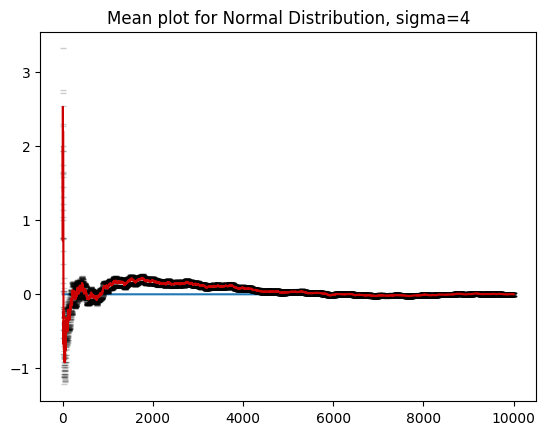

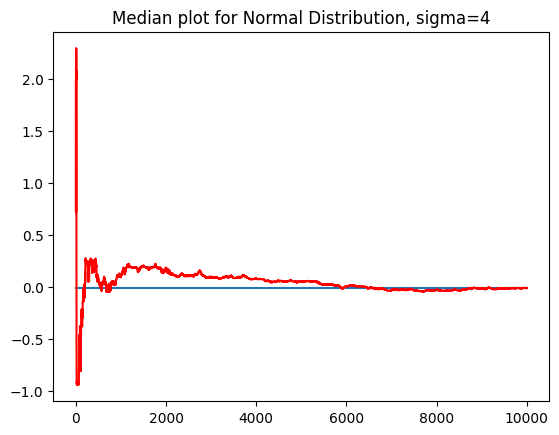

In [8]:
# Gaussian
n = 10_000
sigma = 4
data = np.random.standard_normal(n) * sigma
repeat(data, f'Normal Distribution, sigma={sigma}')

LogNormal Distribution, sigma=4
Mean: 1677.4899958538354
 Median: 0.9907525386538877


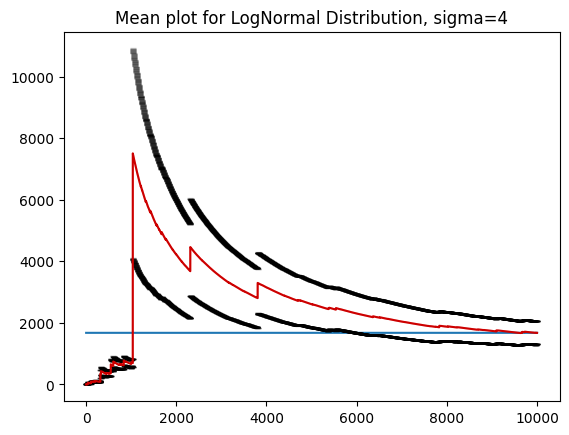

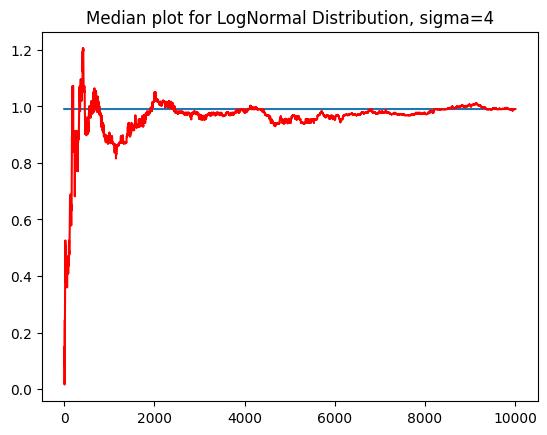

In [10]:
sigma = 4
data = np.random.lognormal(0, sigma, n)
repeat(data, f'LogNormal Distribution, sigma={sigma}')

Pareto distribution with alpha=0.5
Mean: 68271.81596641909
 Median: 3.0516026496648765


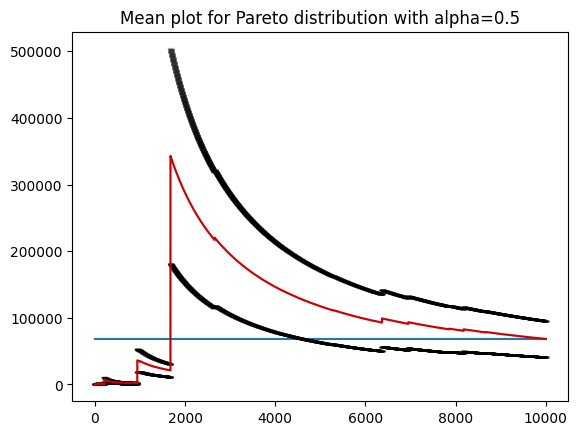

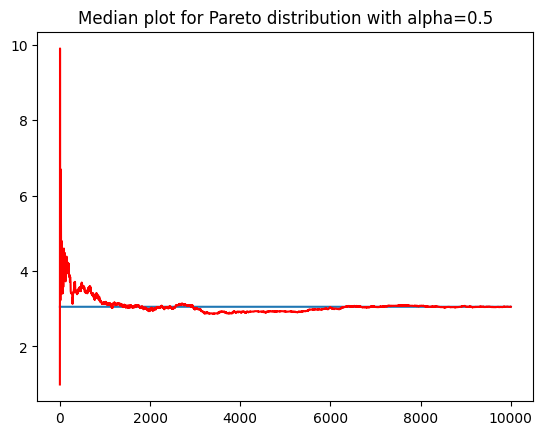

In [12]:
alpha = 0.5
data = np.random.pareto(alpha, n)  # xm = 1 by default
repeat(data, f'Pareto distribution with alpha={alpha}')

Citation Count sample
Mean: 36.893
 Median: 4.0


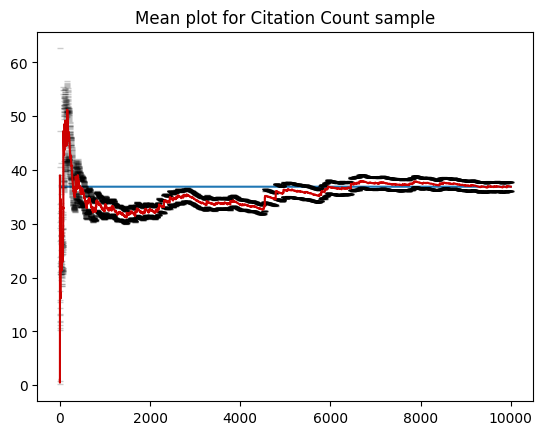

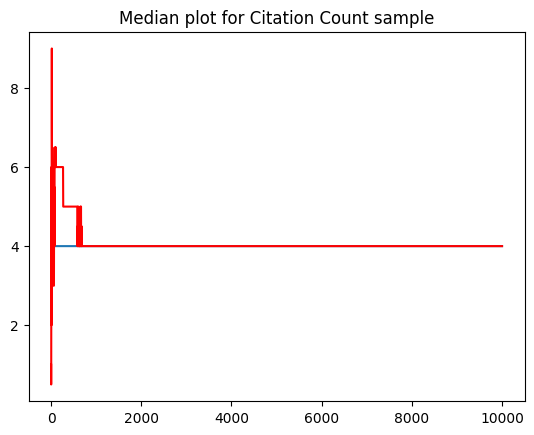

(36.893, 4.0)

In [14]:
df_paper = pd.read_csv('data\\PaperDataset.csv')
data = np.random.choice(df_paper['Citation Count'], n, replace=False)
repeat(data, 'Citation Count sample')
data.mean(), np.median(data)

The Normal and LogNormal distributions' cumulative mean/median tends towards the
Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more usfeul in the different cases?
Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications?
What do you think are the main take-home message of this exercise?